In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.ensemble import IsolationForest
from scipy.stats import mannwhitneyu

Read in the dataset

In [ ]:
df = pd.read_csv('data/twitter_human_bots_dataset.csv')

print(df)

preprocessing and cleaning: check for missing values followed by feature engineering a followers_friends_ratio column

In [7]:
print(df['followers_count'].isnull().any())
print(df['friends_count'].isnull().any())

df['followers_friends_ratio'] = df['followers_count'] / (df['friends_count']+1) # small offset to avoid nan values

False
False


Exploratory Data Analysis stage

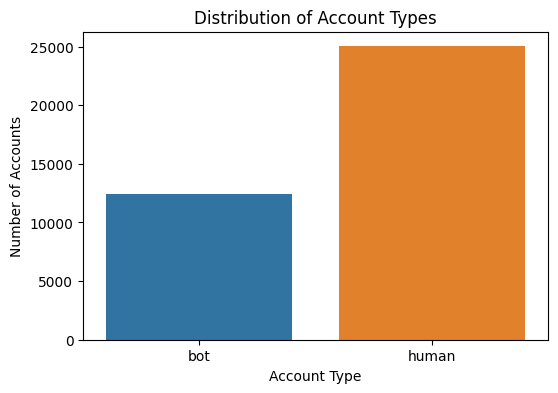

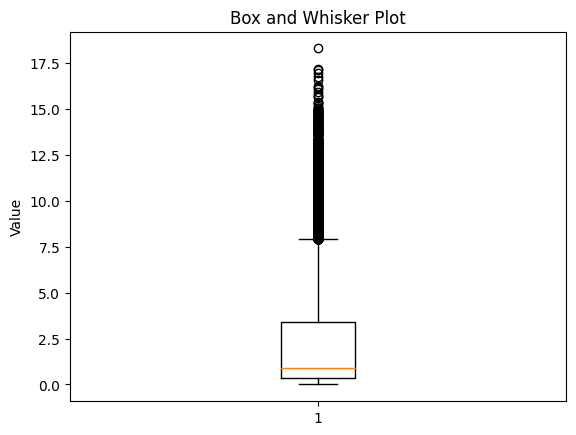

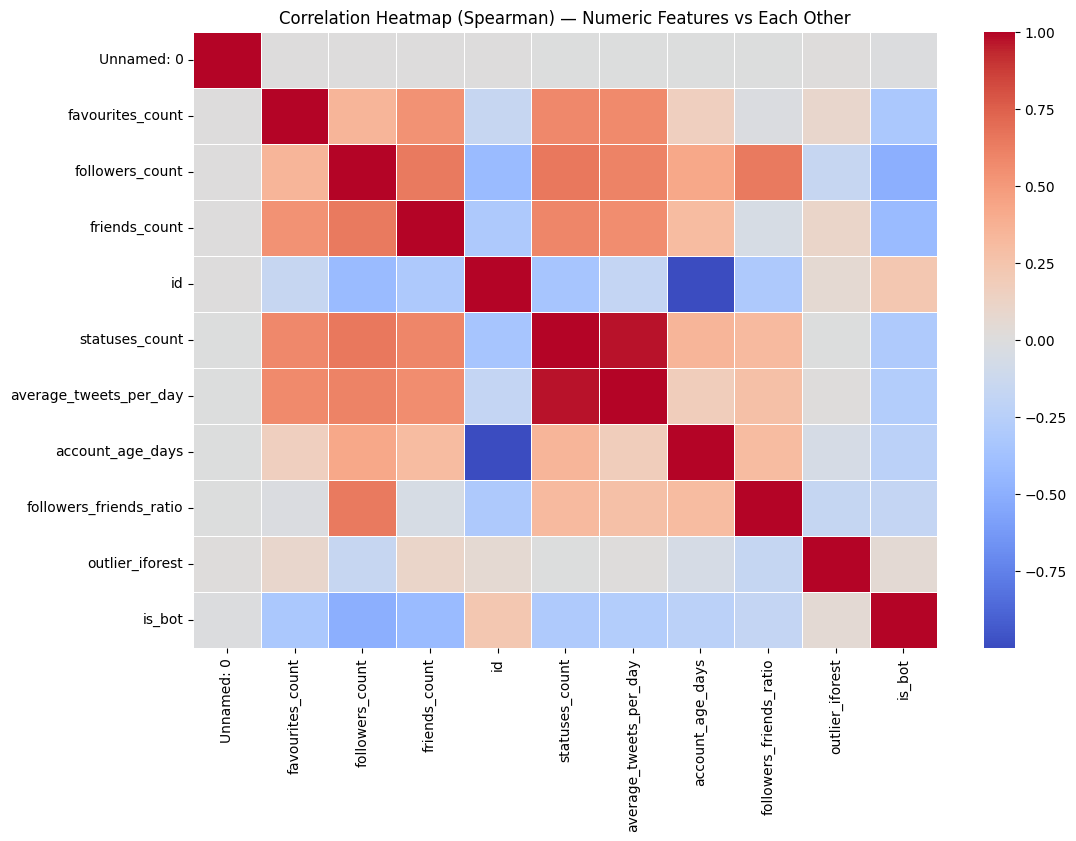

is_bot                     1.000000
id                         0.230022
outlier_iforest            0.048303
Unnamed: 0                -0.014764
followers_friends_ratio   -0.175800
account_age_days          -0.230037
average_tweets_per_day    -0.273598
statuses_count            -0.304257
favourites_count          -0.322031
friends_count             -0.426074
followers_count           -0.501959
Name: is_bot, dtype: float64


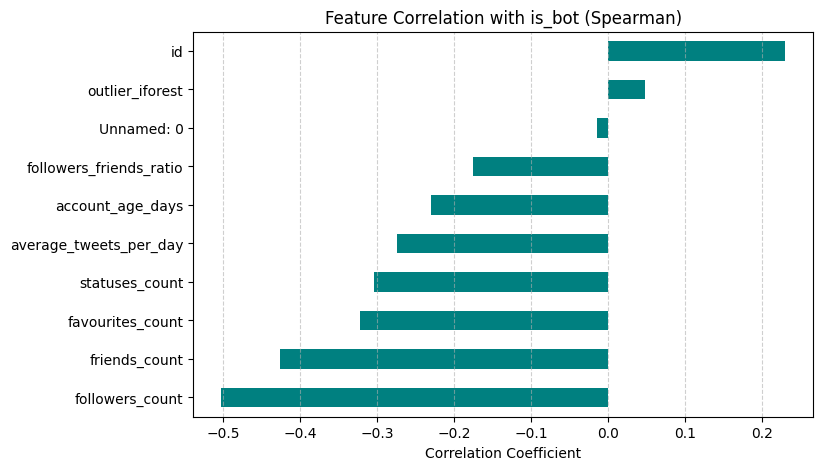

In [16]:
#observe distribution of account types to see if there is a need to apply resampling techniques

plt.figure(figsize=(6,4))
sns.countplot(data=df, x='account_type')

plt.title('Distribution of Account Types')
plt.xlabel('Account Type')
plt.ylabel('Number of Accounts')
plt.show()

# box plot to get rough idea of how many outliers there are from the new feature. The outliers observed can be deemed as bots as per the hypothesis if it is proven to be statistically significant as we will see later.

# using log transform to handle skewness of the distribution

plt.boxplot(np.log1p(df['followers_friends_ratio'].dropna()))
plt.title('Box and Whisker Plot')
plt.ylabel('Value')

plt.show()

# making use of correlation heatmap to get intuition for feature importance 
df['is_bot'] = df['account_type'].str.lower().map({'bot': 1, 'human': 0})

# Select numeric columns only
numeric_df = df.select_dtypes(include=[np.number]).copy()

corr = numeric_df.corr(method='spearman')

plt.figure(figsize=(12,8))
sns.heatmap(
    corr,
    annot=False,           
    cmap='coolwarm',
    center=0,
    linewidths=0.5
)
plt.title("Correlation Heatmap (Spearman) — Numeric Features vs Each Other")
plt.show()

corr_with_target = corr['is_bot'].sort_values(ascending=False)
print(corr_with_target)

plt.figure(figsize=(8,5))
corr_with_target.drop('is_bot').sort_values().plot(kind='barh', color='teal')
plt.title("Feature Correlation with is_bot (Spearman)")
plt.xlabel("Correlation Coefficient")
plt.grid(True, axis='x', linestyle='--', alpha=0.6)
plt.show()

In [17]:
# point out outliers using classic IQR method

Q1 = df['followers_friends_ratio'].quantile(0.25)
Q3 = df['followers_friends_ratio'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers_iqr = df[
    (df['followers_friends_ratio'] < lower_bound) |
    (df['followers_friends_ratio'] > upper_bound)
]

print(f"Detected {len(outliers_iqr)} outliers using IQR method")

Detected 7732 outliers using IQR method


Hypothesis: Bots will have a lower follower:friend ratio than actual human accounts because they tend to spam follow many people (friends) while being followed by little people (followers) to none shortly after creation of the bot account


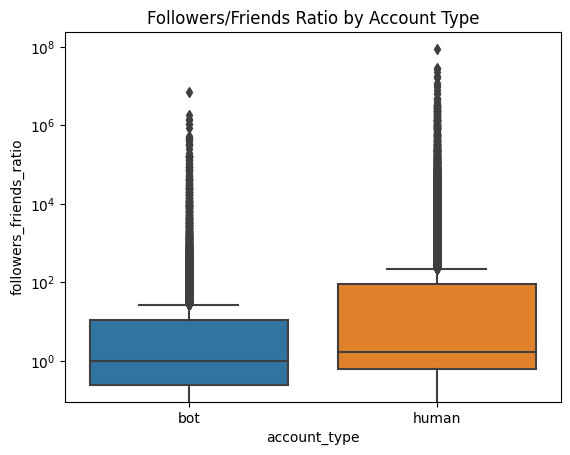

In [18]:
# Visualise boxplot of follower:friend ratio by account type (shud expect bots to have lower ratio as observed by the median)

sns.boxplot(x='account_type', y='followers_friends_ratio', data=df)
plt.title("Followers/Friends Ratio by Account Type")
plt.yscale('log')
plt.show()


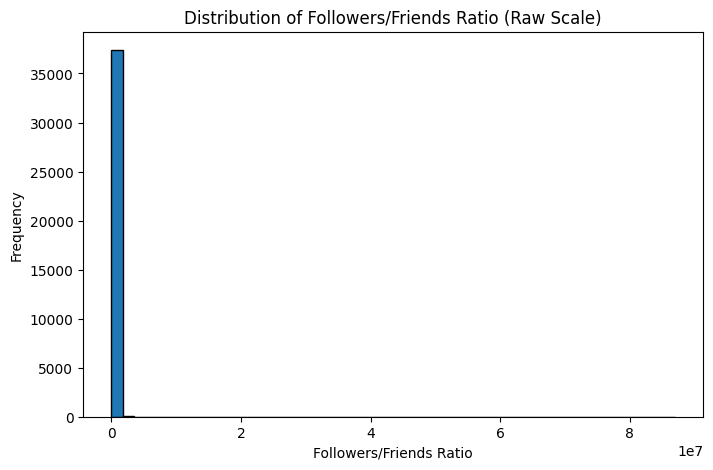

In [19]:
# visualize distribution to see if need use parametric or non-parametric test to prove hypothesis

plt.figure(figsize=(8,5))
plt.hist(df['followers_friends_ratio'], bins=50, edgecolor='black')
plt.title("Distribution of Followers/Friends Ratio (Raw Scale)")
plt.xlabel("Followers/Friends Ratio")
plt.ylabel("Frequency")
plt.show()

It does not seem to follow normal distribution, so we shall use a statistical test called the Mann–Whitney U test to go about the hypothesis.

In [ ]:
bots = df[df['is_bot']==1]['followers_friends_ratio'].dropna()
humans = df[df['is_bot']==0]['followers_friends_ratio'].dropna()
stat, p = mannwhitneyu(bots, humans, alternative='two-sided')
print("Mann-Whitney U p-value:", p)

Mann-Whitney U p-value: 1.3401111835551452e-253


P-value is observed to be <0.05 which means the difference is statistically significant, hence we can support the hypothesis that bots tend to follow more users while having far fewer followers.